# Attention

There are problems where fully connected neural nets and CNNs are not suitable. One of the examples is dealing with sequences of different lengths.

In this notebook, we will see how Self-Attention can solve the sorting problem. Given an arbitrary length sequence of digits, the task is to return sorted one.

```
Input:  [1 1 1 8 4 6 8 5 8 2 6]
Output: [1 1 1 2 4 5 6 6 8 8 8]
```

Let's implement the problem using a generator.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm   # we will use this for progress bars

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [2]:
one_hot = np.eye(10)

def pad(list_of_seq):
    N = max([len(seq) for seq in list_of_seq])
    return torch.stack([F.pad(seq, (0, N - len(seq)))
                        for seq in list_of_seq])

def generator(max_seq_len, batch_size=32):
    one_hot = torch.eye(10)
    while True:
        X = [torch.randint(9, (np.random.randint(max_seq_len),)) + 1
             for _ in range(batch_size)]
        y = [torch.sort(x).values for x in X]
        yield F.one_hot(pad(X), num_classes=10).float(), F.one_hot(pad(y), num_classes=10).float()

Now we can take a look at a small batch.

In [3]:
gen = generator(12, batch_size=5)
X, y = next(gen)
for inp, out in zip(X, y):
    print('\nInput: ', inp.argmax(axis=1))
    print('Output:', out.argmax(axis=1))


Input:  tensor([5, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0])
Output: tensor([4, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0])

Input:  tensor([6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Output: tensor([6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Input:  tensor([7, 6, 4, 7, 4, 9, 5, 6, 1, 1, 1])
Output: tensor([1, 1, 1, 4, 4, 5, 6, 6, 7, 7, 9])

Input:  tensor([6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Output: tensor([4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Input:  tensor([2, 9, 7, 4, 0, 0, 0, 0, 0, 0, 0])
Output: tensor([2, 4, 7, 9, 0, 0, 0, 0, 0, 0, 0])


Note, that zero has different meaning - it is a padding value.

## Self-Attention

In principle idea of self-attention is quite simple. Input vector gets multiplied by three matrixes - $Q, K, V$ to form **Q**uery, **K**ey and **V**alue vectors. Then **Q**uery and **K**ey are combined between the sequences to get weights which are then used to weight **V**alues before summing them up.

![Attention](img/self_attention.gif)

There are a lot of good explanations online if you want to go deeper and understand the math behind it - https://peterbloem.nl/blog/transformers.

## Transformer Block

To use self-attention effectively we need to harness a couple of tricks. The first is to mix it up with fully connected layers and introduce some skip connections.

![Transformer Block](img/transformer_block.png)

Since it is possible to repeat Transformer Blocks let's a for loop (for now it will be executed only once).

In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden, num_heads):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=hidden, num_heads=num_heads)
        self.fc1 = nn.Linear(hidden, hidden * 4)
        self.fc2 = nn.Linear(hidden * 4, hidden)
        self.layer_norm = nn.LayerNorm(hidden, eps=1e-5)
    
    def forward(self, x):
        x = x.permute(1, 0, 2)
        att, _ = self.attention(x, x, x)
        enc = self.layer_norm(x + att)
        enc = enc.permute(1, 0, 2)
        fcn = F.relu(self.fc1(enc))
        fcn = self.fc2(fcn)
        return self.layer_norm(fcn + enc)

class TransformerModel(nn.Module):
    def __init__(self, hidden=32, num_heads=16, num_blocks=1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(10, hidden)
        self.blocks = nn.ModuleList([TransformerBlock(hidden, num_heads) for _ in range(num_blocks)])
        self.output = nn.Linear(hidden, 10)
        
    def forward(self, x):
        x = self.embedding(x)
        for block in self.blocks:
            x = block(x)
        return F.softmax(self.output(x), dim=-1)

Let's define a helper function that plots sequences and an image and prints out a small sample.

In [5]:
# Define the evaluation function
def eval_model(model, gen, seq_to_print=5):
    model.eval()
    with torch.no_grad():
        X, y = next(gen)
        X = X.to(device)
        pred = model(X).argmax(dim=-1).to('cpu')
        real = y.argmax(dim=-1)
        
        # Plotting
        plt.subplot(121)
        plt.imshow(pred)
        plt.axis('off')
        plt.title('Prediction')
        plt.subplot(122)
        plt.imshow(real)
        plt.axis('off')
        plt.title('Actual seq')
        plt.show()
        
        # Print sequences
        for p, a in zip(pred[:seq_to_print], real[:seq_to_print]):
            print('\nPrediction:', p.numpy())
            print('Actual seq:', a.numpy())

Finally we are ready to train a model.

**TODO**: add loss print to this and all other train statements and observe how it changes during training.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it]


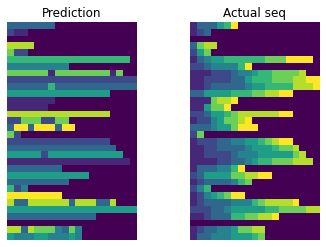


Prediction: [3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [1 3 3 3 5 6 9 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [1 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [8 8 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [3 7 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [7 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [2 5 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
# Generate data, build the model, train, and evaluate
gen = generator(max_seq_len=20)
# Move model to device (use 'cuda' if available, otherwise 'cpu')
model = TransformerModel().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# For faster demonstration reduce the number of epochs
epochs = 10
steps_per_epoch = 200

# Train the model
model.train()
for epoch in tqdm(range(epochs)):
    for step in range(steps_per_epoch):
        X, y = next(gen)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs.permute(0, 2, 1), y.argmax(dim=-1))
        loss.backward()
        optimizer.step()

# Evaluate the model
eval_model(model, gen)

At this point, the model can learn to deal with sequence length and can pick the element that is most common but fails with sorting problem... Clearly, we lack something that allows the model to learn sequential nature.

## Positional Embeddings

To resolve the problem we will add random weights for each position! We fix those *positional embeddings* before generating sequences and then add them to the inputs. The code below should be self-explanatory. 

In [7]:
def positional_generator(max_seq_len):
    positional_embedding = torch.rand((max_seq_len, 10))
    gen = generator(max_seq_len)
    while True:
        X, y = next(gen)
        N = y.shape[1]
        X += positional_embedding[:N]
        yield X, y

Let's retrain the model using updated generator.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


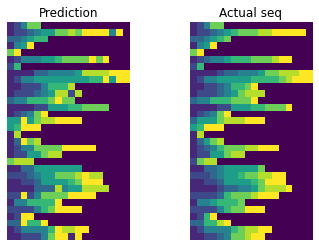


Prediction: [1 2 4 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [1 2 4 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [1 2 2 3 4 5 5 7 7 8 7 9 9 9 9 4 9 0]
Actual seq: [1 2 2 3 4 5 6 7 7 7 8 8 9 9 9 9 9 0]

Prediction: [3 3 4 5 6 6 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [3 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [1 4 5 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [1 4 5 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [7 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [7 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# Generate data, build the model, train, and evaluate
gen = positional_generator(max_seq_len=20)
model = TransformerModel().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in tqdm(range(epochs)):
    for step in range(steps_per_epoch):
        X, y = next(gen)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs.permute(0, 2, 1), y.argmax(dim=-1))
        loss.backward()
        optimizer.step()

# Evaluate the model
eval_model(model, gen)

Much better! You can try to remove the attention layer to convince yourself that this net will fail without it since that disables the passing of the information about other sequence elements. Actually, if we reformulate this problem for fixed length sequences, then flattening and using simple FCN could work, but with arbitrary length sequences, Attention is a way to go.

## Final Architecture

For sure we can add more layers to get more power. It's already implemented above, we just need to pass `num_blocks=3` when constructing the model.

![Transformer Block](img/transformer.png)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:27<00:00,  2.96s/it]


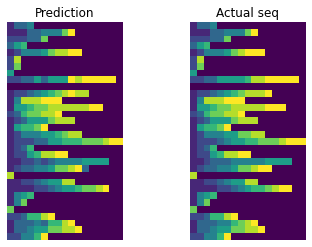


Prediction: [1 3 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [1 3 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [1 1 1 3 3 4 4 4 7 9 0 0 0 0 0 0 0]
Actual seq: [1 1 1 3 3 4 4 4 7 9 0 0 0 0 0 0 0]

Prediction: [2 2 2 3 3 7 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [2 2 2 3 3 7 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [3 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [3 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [1 2 4 4 4 5 7 8 8 9 9 0 0 0 0 0 0]
Actual seq: [1 2 4 4 4 5 7 8 9 9 9 0 0 0 0 0 0]


In [9]:
epochs = 50

# Train another model with three blocks of attention layers using the positional generator
gen = positional_generator(max_seq_len=20)
model = TransformerModel(num_blocks=3).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Train the model
model.train()
for epoch in tqdm(range(epochs)):
    for step in range(steps_per_epoch):
        X, y = next(gen)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs.permute(0, 2, 1), y.argmax(dim=-1))
        loss.backward()
        optimizer.step()

# Evaluate the model
eval_model(model, gen)

Training is still quite fast and this time results are nearly perfect.

## TASK: Sequence prediction

Your goal is to make a model capable of predicting how the sequence will continue. We will use generated sequences comprised of two sinus waves with some added noise.

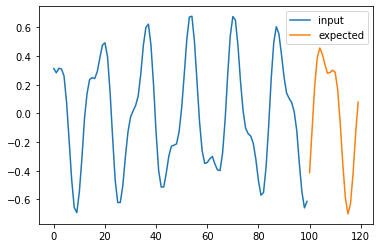

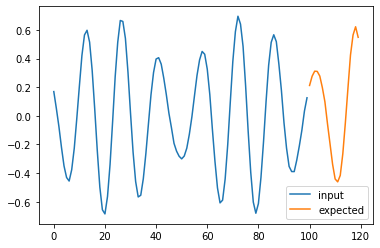

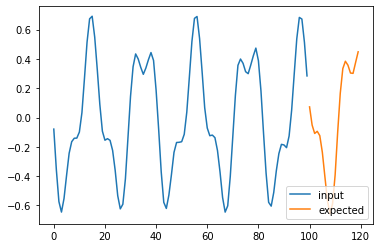

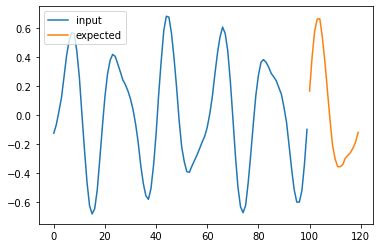

In [10]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 30 + 30))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 60 + 60)) # + wave 2
    series += 0.02 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

n_steps = 100
pred_steps = 20
series = generate_time_series(10000, n_steps + pred_steps)

X_train, Y_train = series[:7000, :n_steps], series[:7000, -pred_steps:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -pred_steps:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -pred_steps:, 0]

# Train a model and make prediction, then validate it using the plots

for i in range(4):
    plt.plot(np.arange(n_steps), X_test[i], label='input')
    plt.plot(np.arange(n_steps, n_steps + pred_steps), Y_test[i], label='expected')
    # plt.plot(np.arange(n_steps, n_steps + pred_steps), pred[i], label='prediction')
    plt.legend()
    plt.show()

### Possible answer

This is not the best way, but what we managed to come up in the lecture without ChatGPT help.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [11:25<00:00, 13.71s/it]


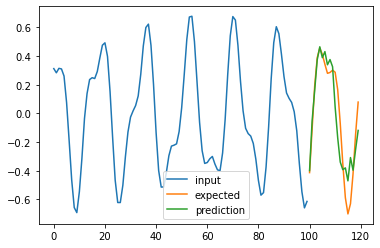

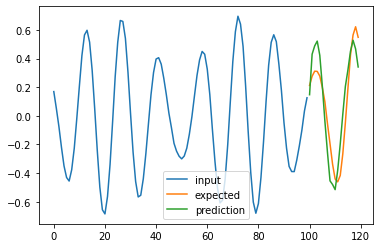

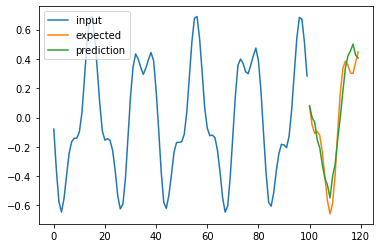

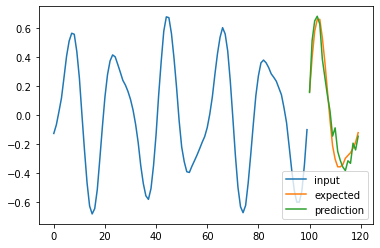

In [11]:
conc = np.concatenate([X_train[:, 20:, 0], Y_train], axis=1)
Y_train_shifted = conc[..., np.newaxis]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_shifted, dtype=torch.float32)

from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train_tensor, Y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class TransformerModel(nn.Module):
    def __init__(self, hidden=32, num_heads=16, num_blocks=1):
        super(TransformerModel, self).__init__()
        self.pos_embedding = torch.tensor(np.random.normal(size=(1, 100, hidden)), dtype=torch.float32).to(device)
        self.embedding = nn.Linear(1, hidden)
        self.blocks = nn.ModuleList([TransformerBlock(hidden, num_heads) for _ in range(num_blocks)])
        self.fcn = nn.Linear(hidden, hidden)
        self.output = nn.Linear(hidden, 1)
        
    def forward(self, x):
        x = self.embedding(x) + self.pos_embedding
        for block in self.blocks:
            x = block(x)
        x = F.relu(self.fcn(x))
        return self.output(x)

epochs = 50
model = TransformerModel(num_blocks=5).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

# tqdm is a simple way to get a progress bar
for epoch in tqdm(range(epochs)):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
pred = model(X_test_tensor.to(device)).to('cpu').detach().numpy()
pred = pred[:, -20:, 0]

for i in range(4):
    plt.plot(np.arange(n_steps), X_test[i], label='input')
    plt.plot(np.arange(n_steps, n_steps + pred_steps), Y_test[i], label='expected')
    plt.plot(np.arange(n_steps, n_steps + pred_steps), pred[i], label='prediction')
    plt.legend()
    plt.show()

## Age of Transformers

Attention is widely used for language and is finding its way into language, voice, vision, and basically any field that uses sequences or can be expressed as a sequence. It was popularized with a paper named [Attention Is All You Need](https://arxiv.org/abs/1706.03762). Usually similarly to autoencoders, there is a block that encodes input data followed by a decoder. It can be from the same domain, for example as in translation problems, but even more interestingly it can be different domains, for example, encoding text and then decoding it as an image!

I highly recommend to listen to the “Cambrian Explosion of generative models” - https://changelog.com/practicalai/230. Note that people often use GPT as a data generator for their projects before training their own models.

**BERT (Bidirectional Encoder Representations from Transformers) - 2018**
- **Dataset**: Trained on BookCorpus (800 million words from 11,038 books) and English Wikipedia (2.5 billion words).
- **Training Objective**: Masked Language Modeling (MLM, masking random words in a sentence) and Next Sentence Prediction (NSP).
- **Architecture**: Bidirectional encoder-only Transformer with 12 layers (BERT-base) or 24 layers (BERT-large).
- **Purpose**: Designed for fine-tuning on various NLP (comprehension) tasks like text classification, question answering, and named entity recognition.
- **Hugging Face Link**: [BERT Models](https://huggingface.co/models?filter=bert)
- **BERT Documentation**: [BERT Model Docs](https://huggingface.co/docs/transformers/model_doc/bert)

**GPT-2 (Generative Pre-trained Transformer 2) - 2019**
- **Dataset**: Approximately 8 million web pages from the WebText dataset (~40 GB of text).
- **Training Objective**: Trained to predict the next word in a sequence (causal language modeling).
- **Architecture**: Unidirectional decoder-only Transformer with up to 1.5 billion parameters.
- **Purpose**: Generates coherent and contextually relevant language output for tasks like text generation and summarization.
- **Hugging Face Link**: [GPT-2 Models](https://huggingface.co/models?filter=gpt2)
- **GPT-2 Documentation**: [GPT-2 Model Docs](https://huggingface.co/docs/transformers/model_doc/gpt2)

**GPT-3 (Generative Pre-trained Transformer 3) - 2020**
- **Dataset**: Trained on a diverse range of internet text, including Common Crawl, WebText2, Books, and Wikipedia (~570 GB).
- **Architecture**: Decoder-only Transformer with 175 billion parameters.
- **Purpose**: Capable of few-shot learning, language translation, question answering, and content generation without task-specific fine-tuning.
- **Hugging Face Link**: GPT-3 models are proprietary and not available on Hugging Face. Access is provided via the [OpenAI API](https://openai.com/api/).

**GPT-4 - 2023**
- **Dataset**: Trained on a diverse dataset including internet text and code (exact details are proprietary).
- **Architecture**: Advanced decoder-only Transformer with an estimated trillions of parameters.
- **Purpose**: Improved reasoning, understanding, and generation capabilities, including support for multimodal inputs (text and images).
- **Hugging Face Link**: GPT-4 is proprietary and not available on Hugging Face. Access is provided via the [OpenAI API](https://openai.com/api/).

**LLaMA (Large Language Model Meta AI) - 2023**
- **Dataset**: Trained on publicly available data sources like Common Crawl, C4, GitHub, Wikipedia, and Stack Exchange.
- **Architecture**: Decoder-only Transformer models ranging from 7 billion to 65 billion parameters.
- **Purpose**: Designed for research to democratize access to large language models.
- **Hugging Face Link**: [LLaMA Models](https://huggingface.co/models?search=llama)

**ViT (Vision Transformer) - 2020**
- **Dataset**: Trained on ImageNet (1.4 million images) and larger datasets like JFT-300M (300 million images).
- **Training Objective**: Image classification.
- **Architecture**: Transformer model adapted for image processing by treating images as sequences of fixed-size patches.
- **Purpose**: Optimized for single-label image classification tasks.
- **Hugging Face Link**: [ViT Models](https://huggingface.co/models?filter=vit)
- **ViT Documentation**: [ViT Model Docs](https://huggingface.co/docs/transformers/model_doc/vit)

**CLIP (Contrastive Language–Image Pre-training) - 2021**
- **Dataset**: 400 million image-text pairs scraped from the internet (WebImageText dataset).
- **Training Objective**: Learns to match images and text through contrastive learning.
- **Architecture**: Comprises an image encoder (ResNet or ViT) and a text encoder (Transformer).
- **Purpose**: Enables tasks like image classification, image/text retrieval, and visual question answering with zero-shot learning capabilities.
- **Hugging Face Link**: [CLIP Models](https://huggingface.co/models?filter=clip)
- **CLIP Blog Post**: [OpenAI CLIP Research](https://openai.com/research/clip)
- **OpenCLIP Repository**: [GitHub](https://github.com/mlfoundations/open_clip)
- **CLIP Interrogator Demo**: [Hugging Face Space](https://huggingface.co/spaces/pharmapsychotic/CLIP-Interrogator)

**OWL-ViT (Open-Vocabulary Object Detection with Vision Transformers) - 2022**
- **Dataset**: Trained on large-scale (~3.6 billion) image-text pairs, including datasets like COCO and Visual Genome.
- **Training Objective**: Open-vocabulary object detection using contrastive learning.
- **Architecture**: Extends ViT for object detection tasks by incorporating region proposals and aligning them with text queries.
- **Purpose**: Detects and localizes objects based on textual input, enabling open-world object detection.
- **Hugging Face Link**: [OWL-ViT Models](https://huggingface.co/models?filter=owlvit)

**BLIP-2 (Bootstrapping Language-Image Pre-training) - 2023**
- **Dataset**: Trained on a combination of datasets including COCO, Visual Genome, Conceptual Captions, SBU, and LAION.
- **Training Objective**: Bridges vision and language models through a two-stage training process for generative tasks.
- **Architecture**: Combines a vision encoder with a language model using a lightweight Q-Former for efficient training.
- **Purpose**: Used for image captioning, visual question answering, and text/image retrieval, focusing on generating detailed text related to images.
- **Hugging Face Link**: [BLIP-2 Models](https://huggingface.co/models?filter=blip-2)
- **BLIP-2 Usage Guide**: [How to Use BLIP-2](https://huggingface.co/blog/blip-2)

**DALL·E 2 - 2022**
- **Dataset**: Trained on hundreds of millions of image-text pairs.
- **Architecture**: Utilizes a diffusion model guided by CLIP embeddings to generate images from textual descriptions.
- **Purpose**: Generates high-resolution, realistic images based on text prompts.
- **Hugging Face Link**: DALL·E 2 is proprietary and not available on Hugging Face. Access is provided via the [OpenAI API](https://openai.com/api/).

**Stable Diffusion - 2022**
- **Dataset**: LAION-5B (5 billion image-text pairs from Common Crawl data).
- **Training Objective**: Text-to-image generation using latent diffusion models.
- **Architecture**: Utilizes a latent diffusion model that compresses images into a latent space and refines them during generation.
- **Purpose**: Generates high-quality images from text prompts.
- **Hugging Face Link**: [Stable Diffusion Models](https://huggingface.co/models?search=stable-diffusion)
- **Stable Diffusion Demo**: [Hugging Face Space](https://huggingface.co/spaces/stabilityai/stable-diffusion)

**Whisper - 2022**
- **Dataset**: 680,000 hours of multilingual and multitask supervised data collected from the web (117,000 hours are non-English).
- **Training Objective**: Speech recognition and translation through next-token prediction from log-mel spectrograms.
- **Architecture**: Encoder-decoder Transformer adapted for audio processing.
- **Purpose**: Provides robust speech recognition and language translation capabilities.
- **Hugging Face Link**: [Whisper Models](https://huggingface.co/models?filter=whisper)
- **Whisper Research**: [OpenAI Whisper](https://openai.com/research/whisper)

**Additional Resources:**
- **Attention Is All You Need**: [Paper](https://arxiv.org/pdf/1706.03762.pdf)
- **Hugging Face Transformers Documentation**: [Transformers](https://huggingface.co/docs/transformers/index)
- **Hugging Face Spaces**: [Explore Demos](https://huggingface.co/spaces?sort=likes)
- **Hugging Face Models**: [Model Hub](https://huggingface.co/models)
- **LLM dev patterns**: https://eugeneyan.com/writing/llm-patterns/
- **LLM attacks**: https://llm-attacks.org/




## (re)Sources:

- Good explanation - https://peterbloem.nl/blog/transformers
- More simple examples - https://github.com/greentfrapp/attention-primer
